In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from umap import UMAP
import sys
sys.path.append('..')
from utils import load_pickle, save_pickle, seed_everything
seed_everything(42)

/home/sagawa/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
target_embedding = np.load("/data1/ReactionT5_neword/task_forward/output_ord/embedding_mean.npy")
print(target_embedding.shape)

(1787274, 768)


In [3]:
# sample 10000 points
sample_idx_target = np.random.choice(target_embedding.shape[0], 10000, replace=False)
target_embedding = target_embedding[sample_idx_target]

In [4]:
# apply UMAP and plot
# umap = UMAP(n_components=2)
# target_embedding_umap = umap.fit_transform(target_embedding)

# save_pickle("/data1/ReactionT5_neword/task_forward/output_ord/umap.pkl", umap)
# np.save("/data1/ReactionT5_neword/task_forward/output_ord/embedding_umap.npy", target_embedding_umap)
target_embedding_umap = np.load("/data1/ReactionT5_neword/task_forward/output_ord/embedding_umap.npy")
print(target_embedding_umap.shape)

(10000, 2)


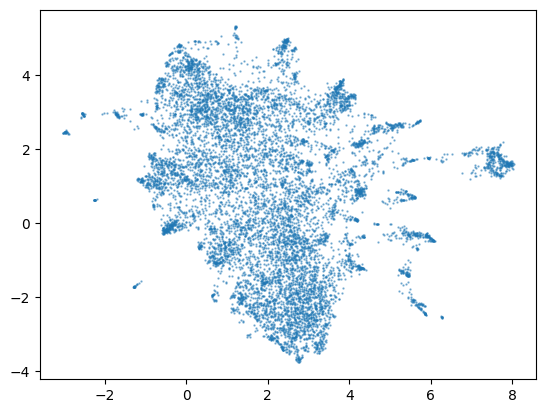

In [5]:
fig, ax = plt.subplots()
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.5, s=0.5)

In [6]:
query_embedding = np.load("/data1/ReactionT5_neword/task_forward/output_uspto_test/embedding_mean.npy")
print(query_embedding.shape)

(40000, 768)


In [7]:
sample_idx_query = np.random.choice(query_embedding.shape[0], 10000, replace=False)
query_embedding = query_embedding[sample_idx_query]
# query_embedding_umap = umap.transform(query_embedding)
# np.save("/data1/ReactionT5_neword/task_forward/output_uspto_test/query_embedding_umap.npy", query_embedding_umap)
query_embedding_umap = np.load("/data1/ReactionT5_neword/task_forward/output_uspto_test/query_embedding_umap.npy")
print(query_embedding_umap.shape)

(10000, 2)


/tmp/ipykernel_2918/3974279845.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
/tmp/ipykernel_2918/3974279845.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)


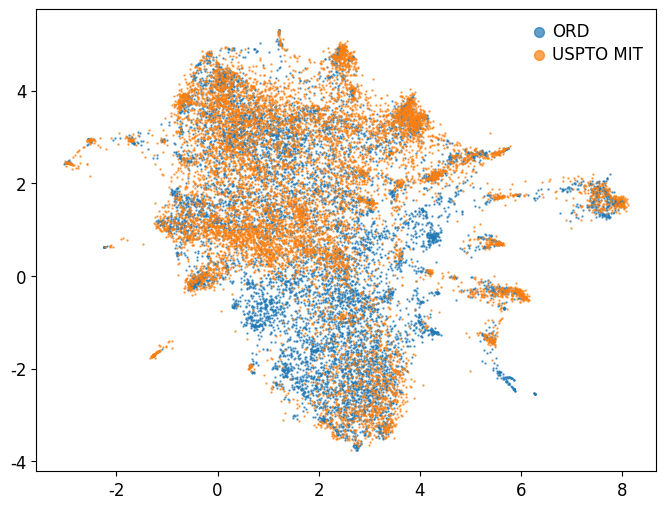

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.7, s=0.5, label="ORD")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.7, s=0.5, label="USPTO MIT")
# ax.set_xlabel("UMAP 1")
# ax.set_ylabel("UMAP 2")
ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)
ax.legend(  
    loc='upper right',
    fontsize=12,
    markerscale=10,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)

In [11]:
df_target = pd.read_csv("/data1/ReactionT5_neword/task_forward/output_ord/input_data.csv")
df_target = df_target.iloc[sample_idx_target].reset_index(drop=True)
df_query = pd.read_csv("/data1/ReactionT5_neword/task_forward/output_uspto_test/input_data.csv")
df_query = df_query.iloc[sample_idx_query].reset_index(drop=True)

df_target["input"] = df_target["input"].apply(lambda x: x.replace("REACTANT:", "").replace("REAGENT:", ".").replace(". ", ""))
df_query["input"] = df_query["input"].apply(lambda x: x.replace("REACTANT:", "").replace("REAGENT:", ".").replace(". ", ""))

In [12]:
# calculate the molecular weight
from rdkit import Chem
from rdkit.Chem import Descriptors
# silence warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
for df in [df_target, df_query]:
    df["mol"] = df["input"].apply(Chem.MolFromSmiles)
    df["mw"] = df["mol"].apply(Descriptors.MolWt)
    df["logp"] = df["mol"].apply(Descriptors.MolLogP)
    df["hba"] = df["mol"].apply(Descriptors.NumHAcceptors)
    df["hbd"] = df["mol"].apply(Descriptors.NumHDonors)
    df["tpsa"] = df["mol"].apply(Descriptors.TPSA)
    df["rotb"] = df["mol"].apply(Descriptors.NumRotatableBonds)
    df["atoms"] = df["mol"].apply(Descriptors.HeavyAtomCount)
    df["rings"] = df["mol"].apply(Descriptors.RingCount)
    df["qed"] = df["mol"].apply(Descriptors.qed)

<Axes: >

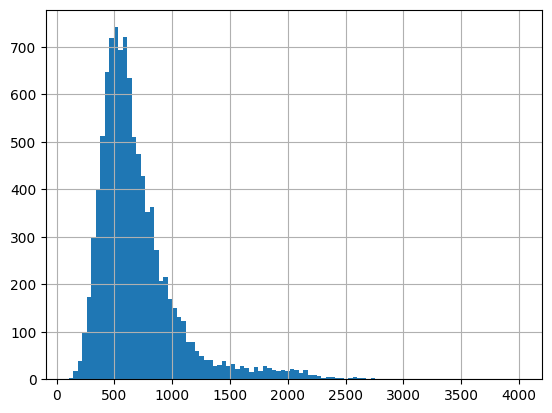

In [13]:
df_target["mw"].hist(bins=100)

/tmp/ipykernel_2918/3548239254.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
/tmp/ipykernel_2918/3548239254.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)


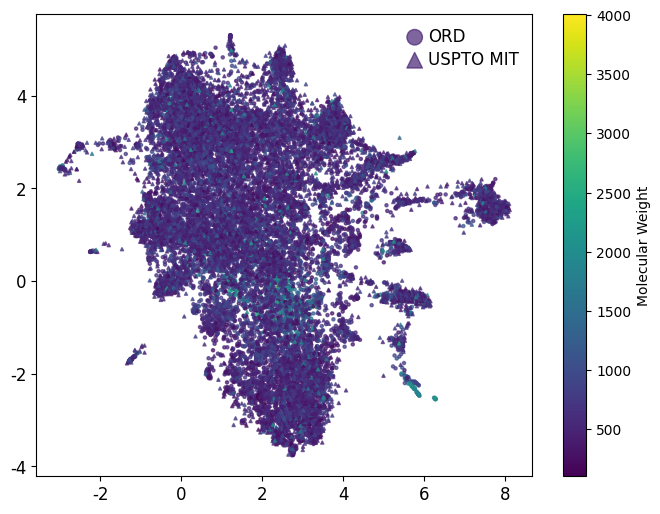

In [24]:
# color by molecular weight
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["mw"].min(), df_query["mw"].min()), max(df_target["mw"].max(), df_query["mw"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.7, s=5, label="ORD", c=cmap(norm(df_target["mw"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.7, s=5, label="USPTO MIT", c=cmap(norm(df_query["mw"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Molecular Weight")
ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)
ax.legend(  
    loc='upper right',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)
plt.show()

/tmp/ipykernel_2918/3897618453.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
/tmp/ipykernel_2918/3897618453.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)


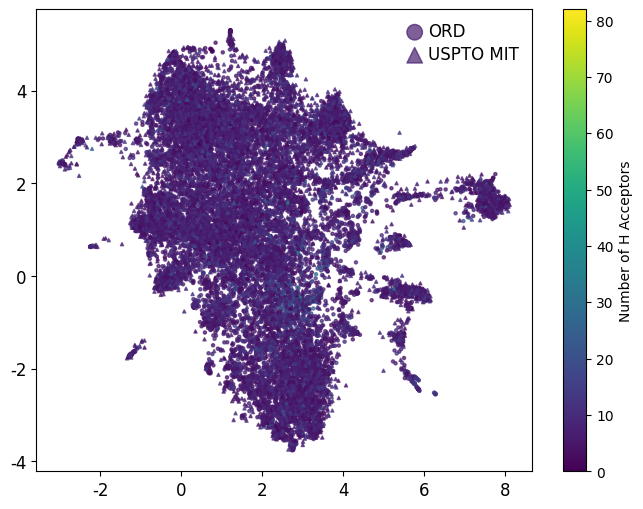

In [26]:

cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["hba"].min(), df_query["hba"].min()), max(df_target["hba"].max(), df_query["hba"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.7, s=5, label="ORD", c=cmap(norm(df_target["hba"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.7, s=5, label="USPTO MIT", c=cmap(norm(df_query["hba"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Number of H Acceptors")
ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)
ax.legend(  
    loc='upper right',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)
plt.show()

/tmp/ipykernel_2918/3246877567.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
/tmp/ipykernel_2918/3246877567.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)


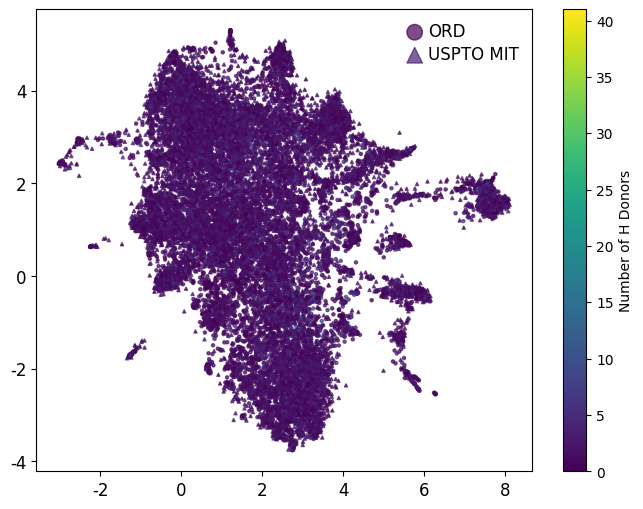

In [34]:

cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["hbd"].min(), df_query["hbd"].min()), max(df_target["hbd"].max(), df_query["hbd"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.7, s=5, label="ORD", c=cmap(norm(df_target["hbd"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.7, s=5, label="USPTO MIT", c=cmap(norm(df_query["hbd"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Number of H Donors")
ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)
ax.legend(  
    loc='upper right',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)
plt.show()

/tmp/ipykernel_2918/1217136388.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
/tmp/ipykernel_2918/1217136388.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)


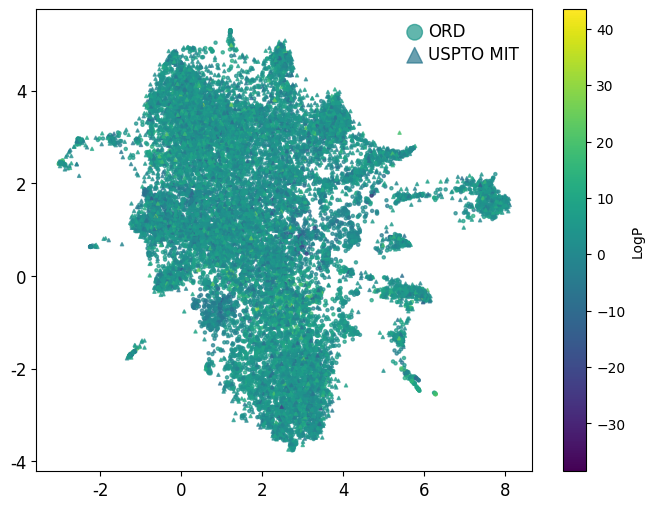

In [33]:

cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["logp"].min(), df_query["logp"].min()), max(df_target["logp"].max(), df_query["logp"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.7, s=5, label="ORD", c=cmap(norm(df_target["logp"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.7, s=5, label="USPTO MIT", c=cmap(norm(df_query["logp"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="LogP")
ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)
ax.legend(  
    loc='upper right',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)
plt.show()

/tmp/ipykernel_2918/1904265242.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
/tmp/ipykernel_2918/1904265242.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)


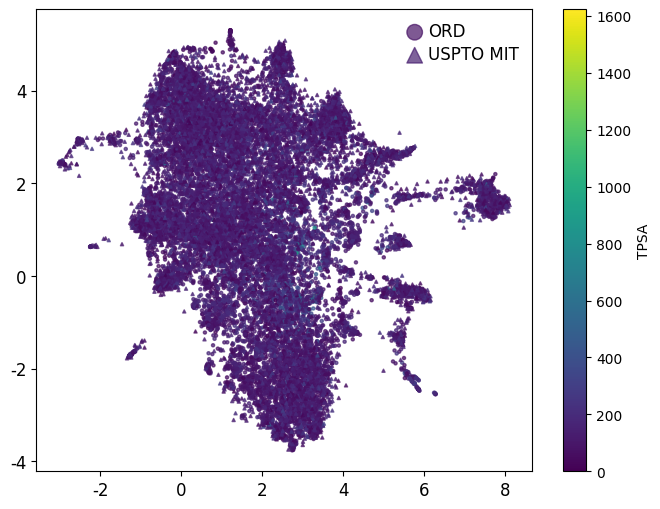

In [28]:

cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["tpsa"].min(), df_query["tpsa"].min()), max(df_target["tpsa"].max(), df_query["tpsa"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.7, s=5, label="ORD", c=cmap(norm(df_target["tpsa"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.7, s=5, label="USPTO MIT", c=cmap(norm(df_query["tpsa"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="TPSA")
ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)
ax.legend(  
    loc='upper right',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)
plt.show()

/tmp/ipykernel_2918/3324959963.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
/tmp/ipykernel_2918/3324959963.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)


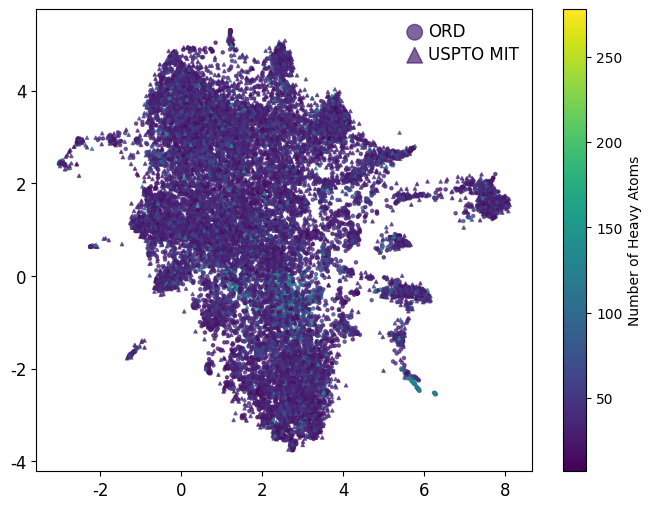

In [29]:

cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["atoms"].min(), df_query["atoms"].min()), max(df_target["atoms"].max(), df_query["atoms"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.7, s=5, label="ORD", c=cmap(norm(df_target["atoms"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.7, s=5, label="USPTO MIT", c=cmap(norm(df_query["atoms"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Number of Heavy Atoms")
ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)
ax.legend(  
    loc='upper right',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)
plt.show()

/tmp/ipykernel_2918/4090932942.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
/tmp/ipykernel_2918/4090932942.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)


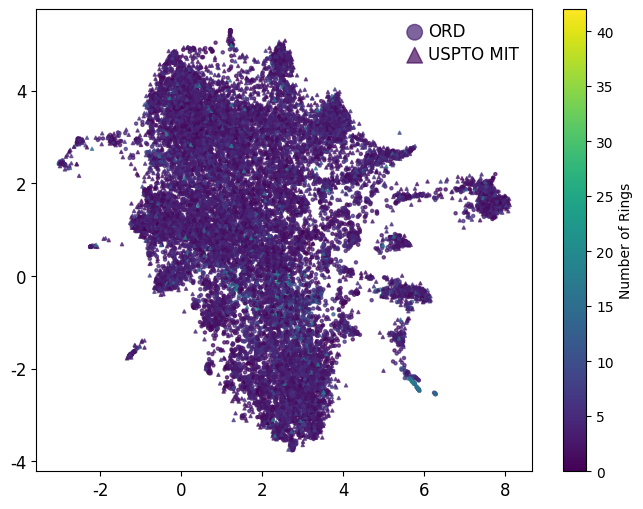

In [31]:

cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["rings"].min(), df_query["rings"].min()), max(df_target["rings"].max(), df_query["rings"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.7, s=5, label="ORD", c=cmap(norm(df_target["rings"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.7, s=5, label="USPTO MIT", c=cmap(norm(df_query["rings"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Number of Rings")
ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)
ax.legend(  
    loc='upper right',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)
plt.show()

In [35]:
from transformers import AutoTokenizer 
tokenizer = AutoTokenizer.from_pretrained("sagawa/ReactionT5v2-forward")
for df in [df_target, df_query]:
    df["input_len"] = df["input"].apply(lambda x: len(tokenizer(x)["input_ids"]))

/home/sagawa/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


/tmp/ipykernel_2918/2527720279.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
/tmp/ipykernel_2918/2527720279.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)


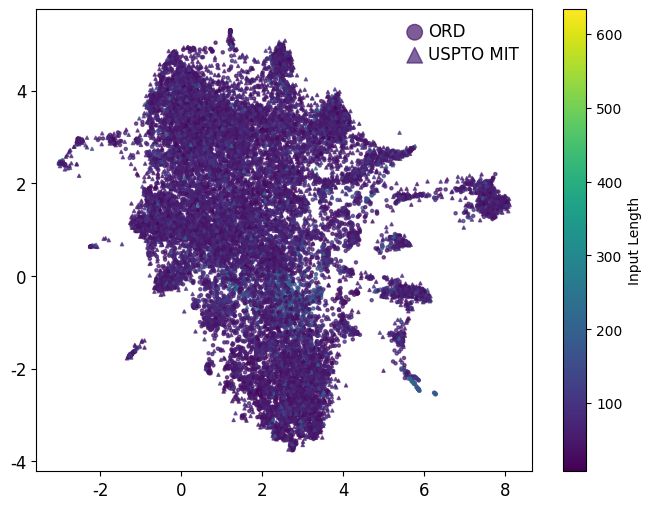

In [36]:

cmap = plt.get_cmap("viridis")
norm = plt.Normalize(min(df_target["input_len"].min(), df_query["input_len"].min()), max(df_target["input_len"].max(), df_query["input_len"].max()))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.7, s=5, label="ORD", c=cmap(norm(df_target["input_len"])), marker="o")
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.7, s=5, label="USPTO MIT", c=cmap(norm(df_query["input_len"])), marker="^")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Input Length")
ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=12)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)
ax.legend(  
    loc='upper right',
    fontsize=12,
    markerscale=5,
    frameon=False,
    labelspacing=0.3,
    borderpad=0.3,
    handletextpad=0.3,
    handlelength=1
)
plt.show()

# visualize distance

In [3]:
distance = pd.read_csv("/data1/ReactionT5_neword/task_forward/output_uspto_test/distance.csv")
distance

,Unnamed: 0,REACTANT,REAGENT,PRODUCT,input,CATALYST,SOLVENT,distance
0,0,N#Cc1ccsc1N.O=[N+]([O-])c1cc(F)c(F)cc1F,C1CCOC1.[H-].[Na+],N#Cc1ccsc1Nc1cc(F)c(F)cc1[N+](=O)[O-],REACTANT:N#Cc1ccsc1N.O=[N+]([O-])c1cc(F)c(F)cc...,,,0.933787
1,1,COC(=O)Cc1cn(C)c2cc(O)ccc12.Cc1nn(-c2ccc(C(F)(...,CCCCP(CCCC)CCCC.Cc1ccccc1,COC(=O)Cc1cn(C)c2cc(OCC(C)c3cn(-c4ccc(C(F)(F)F...,REACTANT:COC(=O)Cc1cn(C)c2cc(O)ccc12.Cc1nn(-c2...,,,0.902206
2,2,Cl.NC1CCN(CC2Cn3c(=O)ccc4ncc(F)c2c43)CC1O.O=Cc...,CCOCC.Cl.ClC(Cl)Cl,O=c1ccc2ncc(F)c3c2n1CC3CN1CCC(NCc2cc3c(cn2)OCS...,REACTANT:Cl.NC1CCN(CC2Cn3c(=O)ccc4ncc(F)c2c43)...,,,0.883629
3,3,C=C(C)C(=O)Cl.CC(C)=C1C(=O)N(c2ccc(O)cc2)C(=O)...,CCN(CC)CC.ClCCl,C=C(C)C(=O)Oc1ccc(N2C(=O)C(=C(C)C)C(=C(C)c3cc(...,REACTANT:C=C(C)C(=O)Cl.CC(C)=C1C(=O)N(c2ccc(O)...,,,0.974624
4,4,O=Cc1cncc(Cl)c1COC1CCCCO1,OCc1c(Cl)cncc1Cl,OCc1cncc(Cl)c1COC1CCCCO1,REACTANT:O=Cc1cncc(Cl)c1COC1CCCCO1REAGENT:OCc1...,,,0.637379
...,...,...,...,...,...,...,...,...
39995,39995,COC(=O)NCC1Cc2c(Cl)cc3c(c2O1)CCC3,[Al+3].[H-].[H-].[H-].[H-].[Li+],CNCC1Cc2c(Cl)cc3c(c2O1)CCC3,REACTANT:COC(=O)NCC1Cc2c(Cl)cc3c(c2O1)CCC3REAG...,,,0.975840
39996,39996,COc1cccc(C(=O)Cl)c1.COc1ccccc1OC,COc1ccc(C(=CC#N)c2ccc(OC)c(OC)c2)cc1.ClCCl.[Al...,COc1cccc(C(=O)c2ccc(OC)c(OC)c2)c1,REACTANT:COc1cccc(C(=O)Cl)c1.COc1ccccc1OCREAGE...,,,0.869934
39997,39997,C#Cc1cccc(C2C(C(=O)OC)=C(C)NC(C(OC)OC)=C2C(=O)...,CC(C)=O.Cl,C#Cc1cccc(C2C(C(=O)OC)=C(C)NC(C=O)=C2C(=O)OC)c1,REACTANT:C#Cc1cccc(C2C(C(=O)OC)=C(C)NC(C(OC)OC...,,,0.877674
39998,39998,CO.COc1ccc(CC(=O)c2ccc(O)cc2O)cc1,,COc1ccc(CC(=O)c2ccc(OC)cc2O)cc1,REACTANT:CO.COc1ccc(CC(=O)c2ccc(O)cc2O)cc1REAG...,,,0.889612


/tmp/ipykernel_3476578/97392767.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)


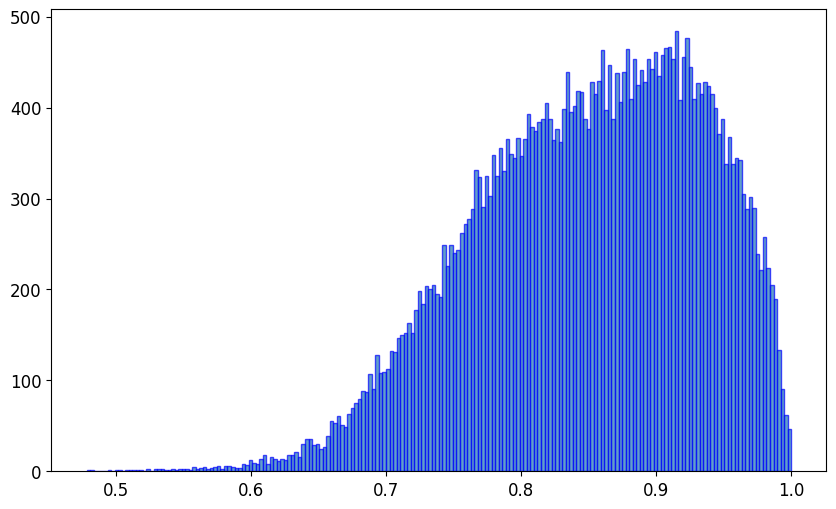

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
distance["distance"].hist(bins=200, ax=ax, edgecolor="b", alpha=0.7)
ax.set_xticks(np.arange(0.5, 1.05, 0.1))
ax.set_xticklabels([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=12)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=12)
ax.grid(axis="y", alpha=0)
ax.grid(axis="x", alpha=0)